<img src="../assets/ga-logo.png" style="float: left; margin: 20px; height: 55px">

# K-Means Clustering with Seeds Data

---

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
%matplotlib inline 

import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import pairwise_distances, silhouette_score
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot') 

import seaborn as sns

### 1. Import the data

In [3]:
seeds = pd.read_csv("data/seeds.csv")

In [4]:
# A: 
seeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   area             210 non-null    float64
 1   perimeter        210 non-null    float64
 2   compactness      210 non-null    float64
 3   length           210 non-null    float64
 4   width            210 non-null    float64
 5   asymmetry_coeff  210 non-null    float64
 6   groove_length    210 non-null    float64
 7   species          210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.3 KB


### 2. Do some EDA of relationships between features.

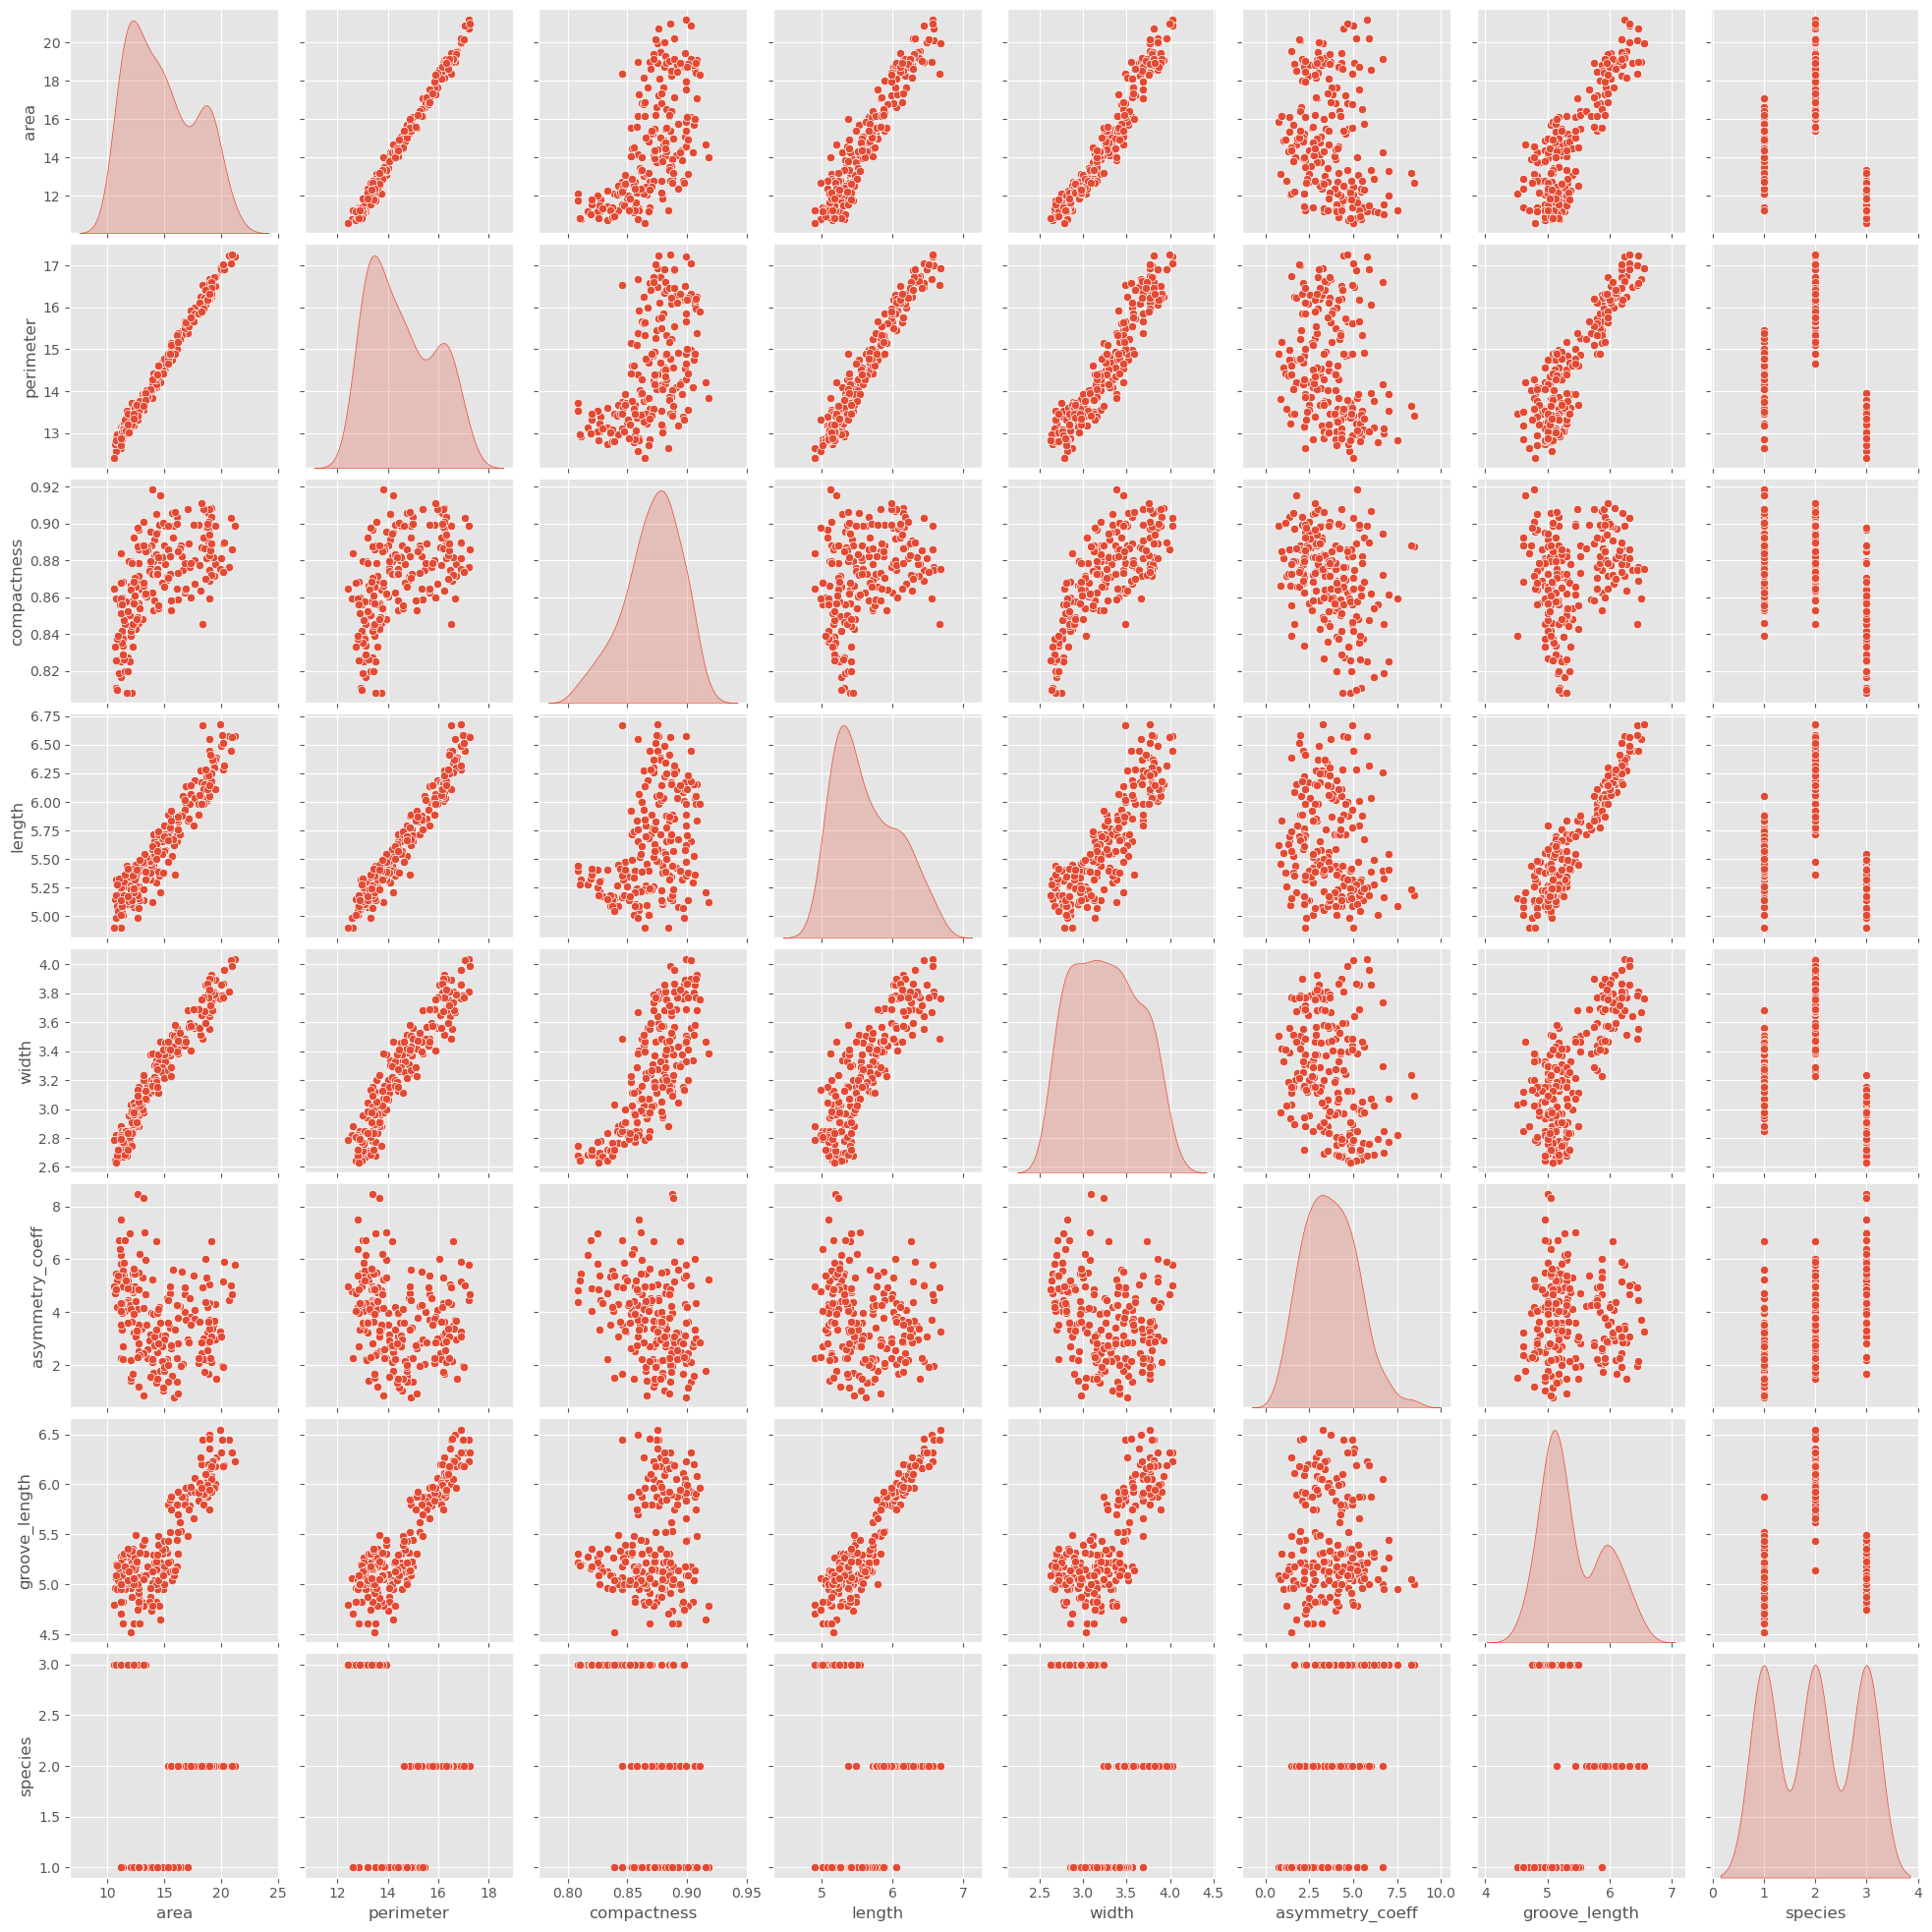

In [5]:
# Plot the Data to see the distributions/relationships
sns.pairplot(seeds, diag_kind="kde")
plt.show()

<Figure size 1500x1000 with 0 Axes>

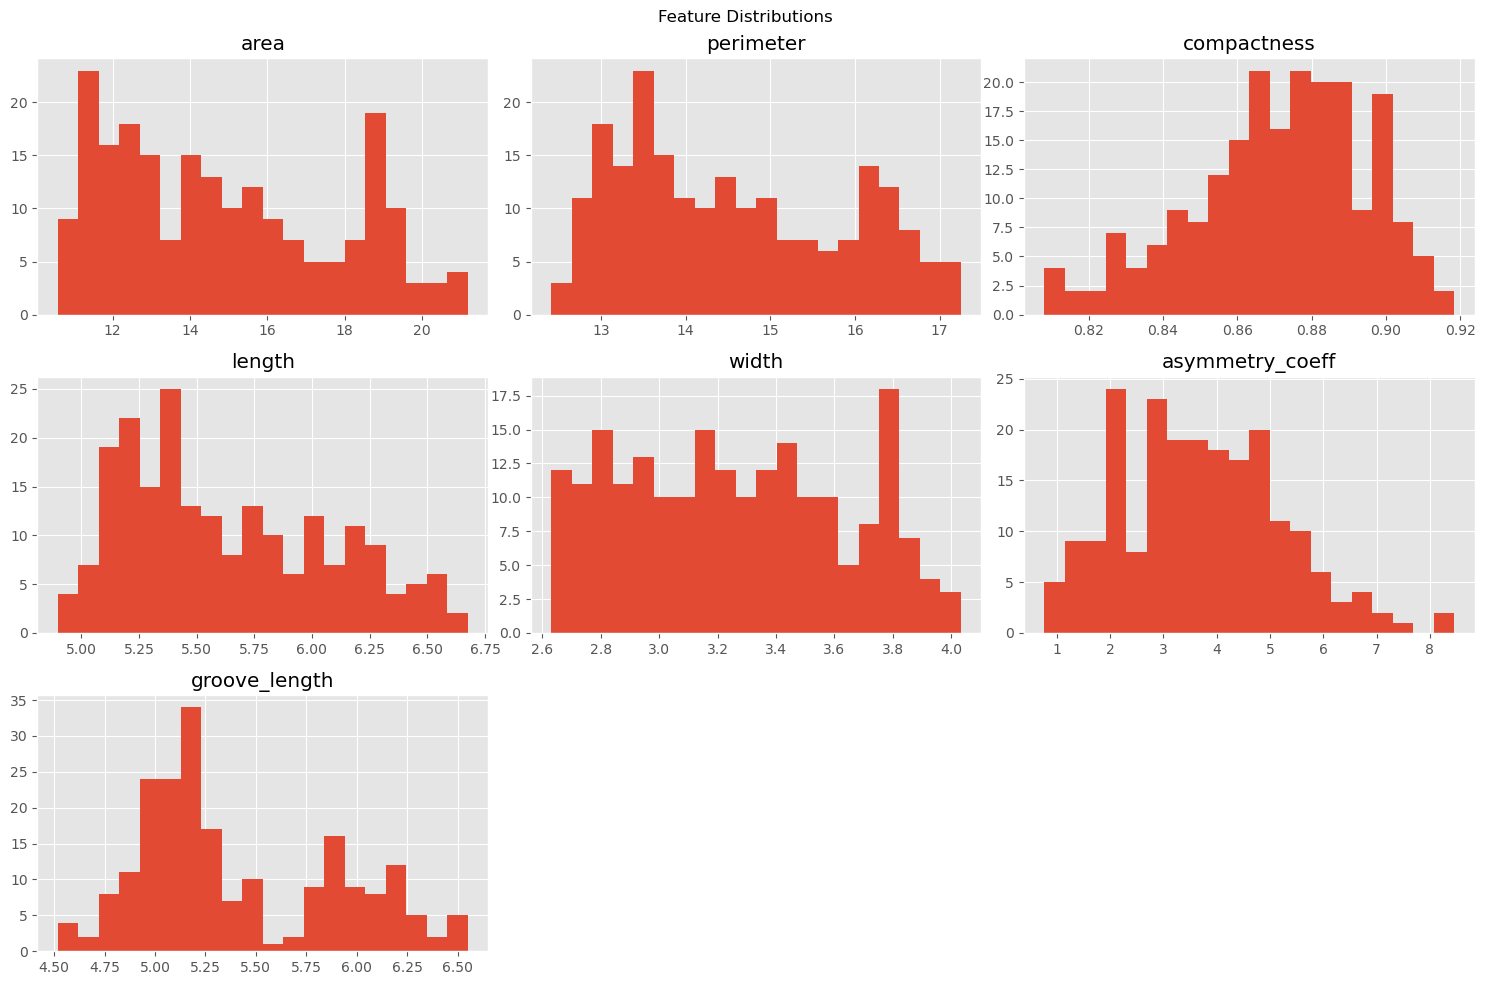

In [6]:
plt.figure(figsize=(15, 10))
seeds.iloc[:, :-1].hist(bins=20, figsize=(15, 10), layout=(3, 3))
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()

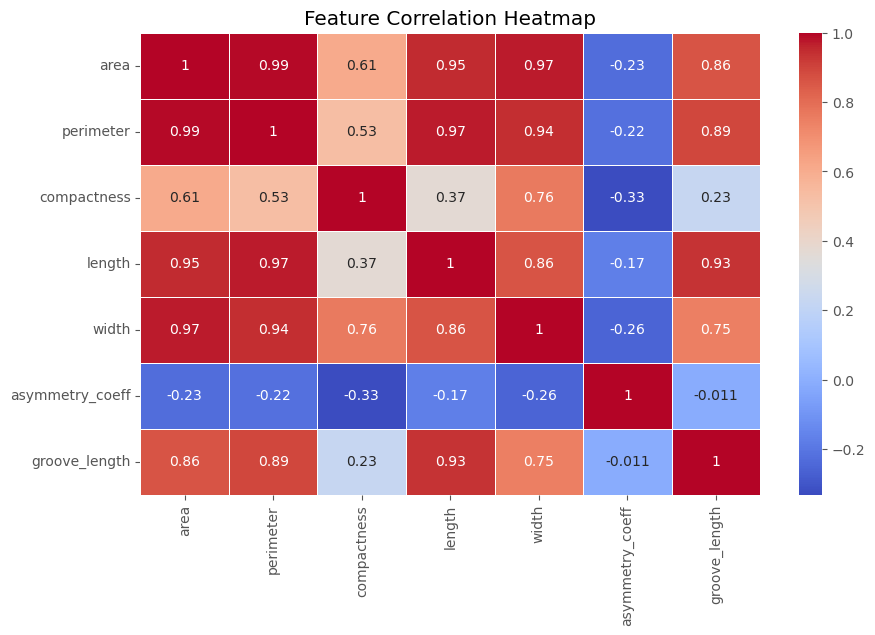

In [7]:
plt.figure(figsize=(10, 6))
corr = seeds.iloc[:, :-1].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
# Check for nulls
seeds.isnull().sum()

area               0
perimeter          0
compactness        0
length             0
width              0
asymmetry_coeff    0
groove_length      0
species            0
dtype: int64

In [9]:
# Look at the real species labels.
seeds['species'].value_counts()

species
1    70
2    70
3    70
Name: count, dtype: int64

Remember, clustering is a unsupervised learning method so known classes will never be a thing.  In this situation we can see that the `perimiter` vs. `groove_length` is a good visualization to view the proper classes class, and we can use later to compare the results of clustering to a true value.

### 3. Prepare the data for clustering

1. Remove the `species` column. We will see if the clusters from K-Means end up like the actual species.
2. Put the features on the same scale.

In [10]:
# A:
X = seeds.drop('species', axis = 1)
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

### 4. Clustering with K-Means

- Cluster the data to our our target groups.
- We know that there are 3 actual classes. However, in an actual situation in which we used clustering we would have no idea. Lets initally try using the default K for `KMeans`(8).

In [11]:
km = KMeans(n_clusters=8, random_state=42)
km.fit(X_scaled)

KMeans(random_state=42)

### 5. Get the labels and centroids for out first clustering model.

In [12]:
# A:
seeds['cluster'] = km.labels_
seeds.head()

,area,perimeter,compactness,length,width,asymmetry_coeff,groove_length,species,cluster
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1,2
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1,2
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1,6
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1,6
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1,2


### 6. Compute the silouette score and visually examine the results of the 8 clusters. 

_(pairplot with hue)_

In [13]:
# A:
np.set_printoptions(legacy='1.25')
silhouette_score(X_scaled, km.labels_)

0.24723000842863302

In [14]:
labels = km.labels_
score = silhouette_score(X_scaled, labels)
print("Silhouette Score (K=8):", score)

Silhouette Score (K=8): 0.24723000842863302


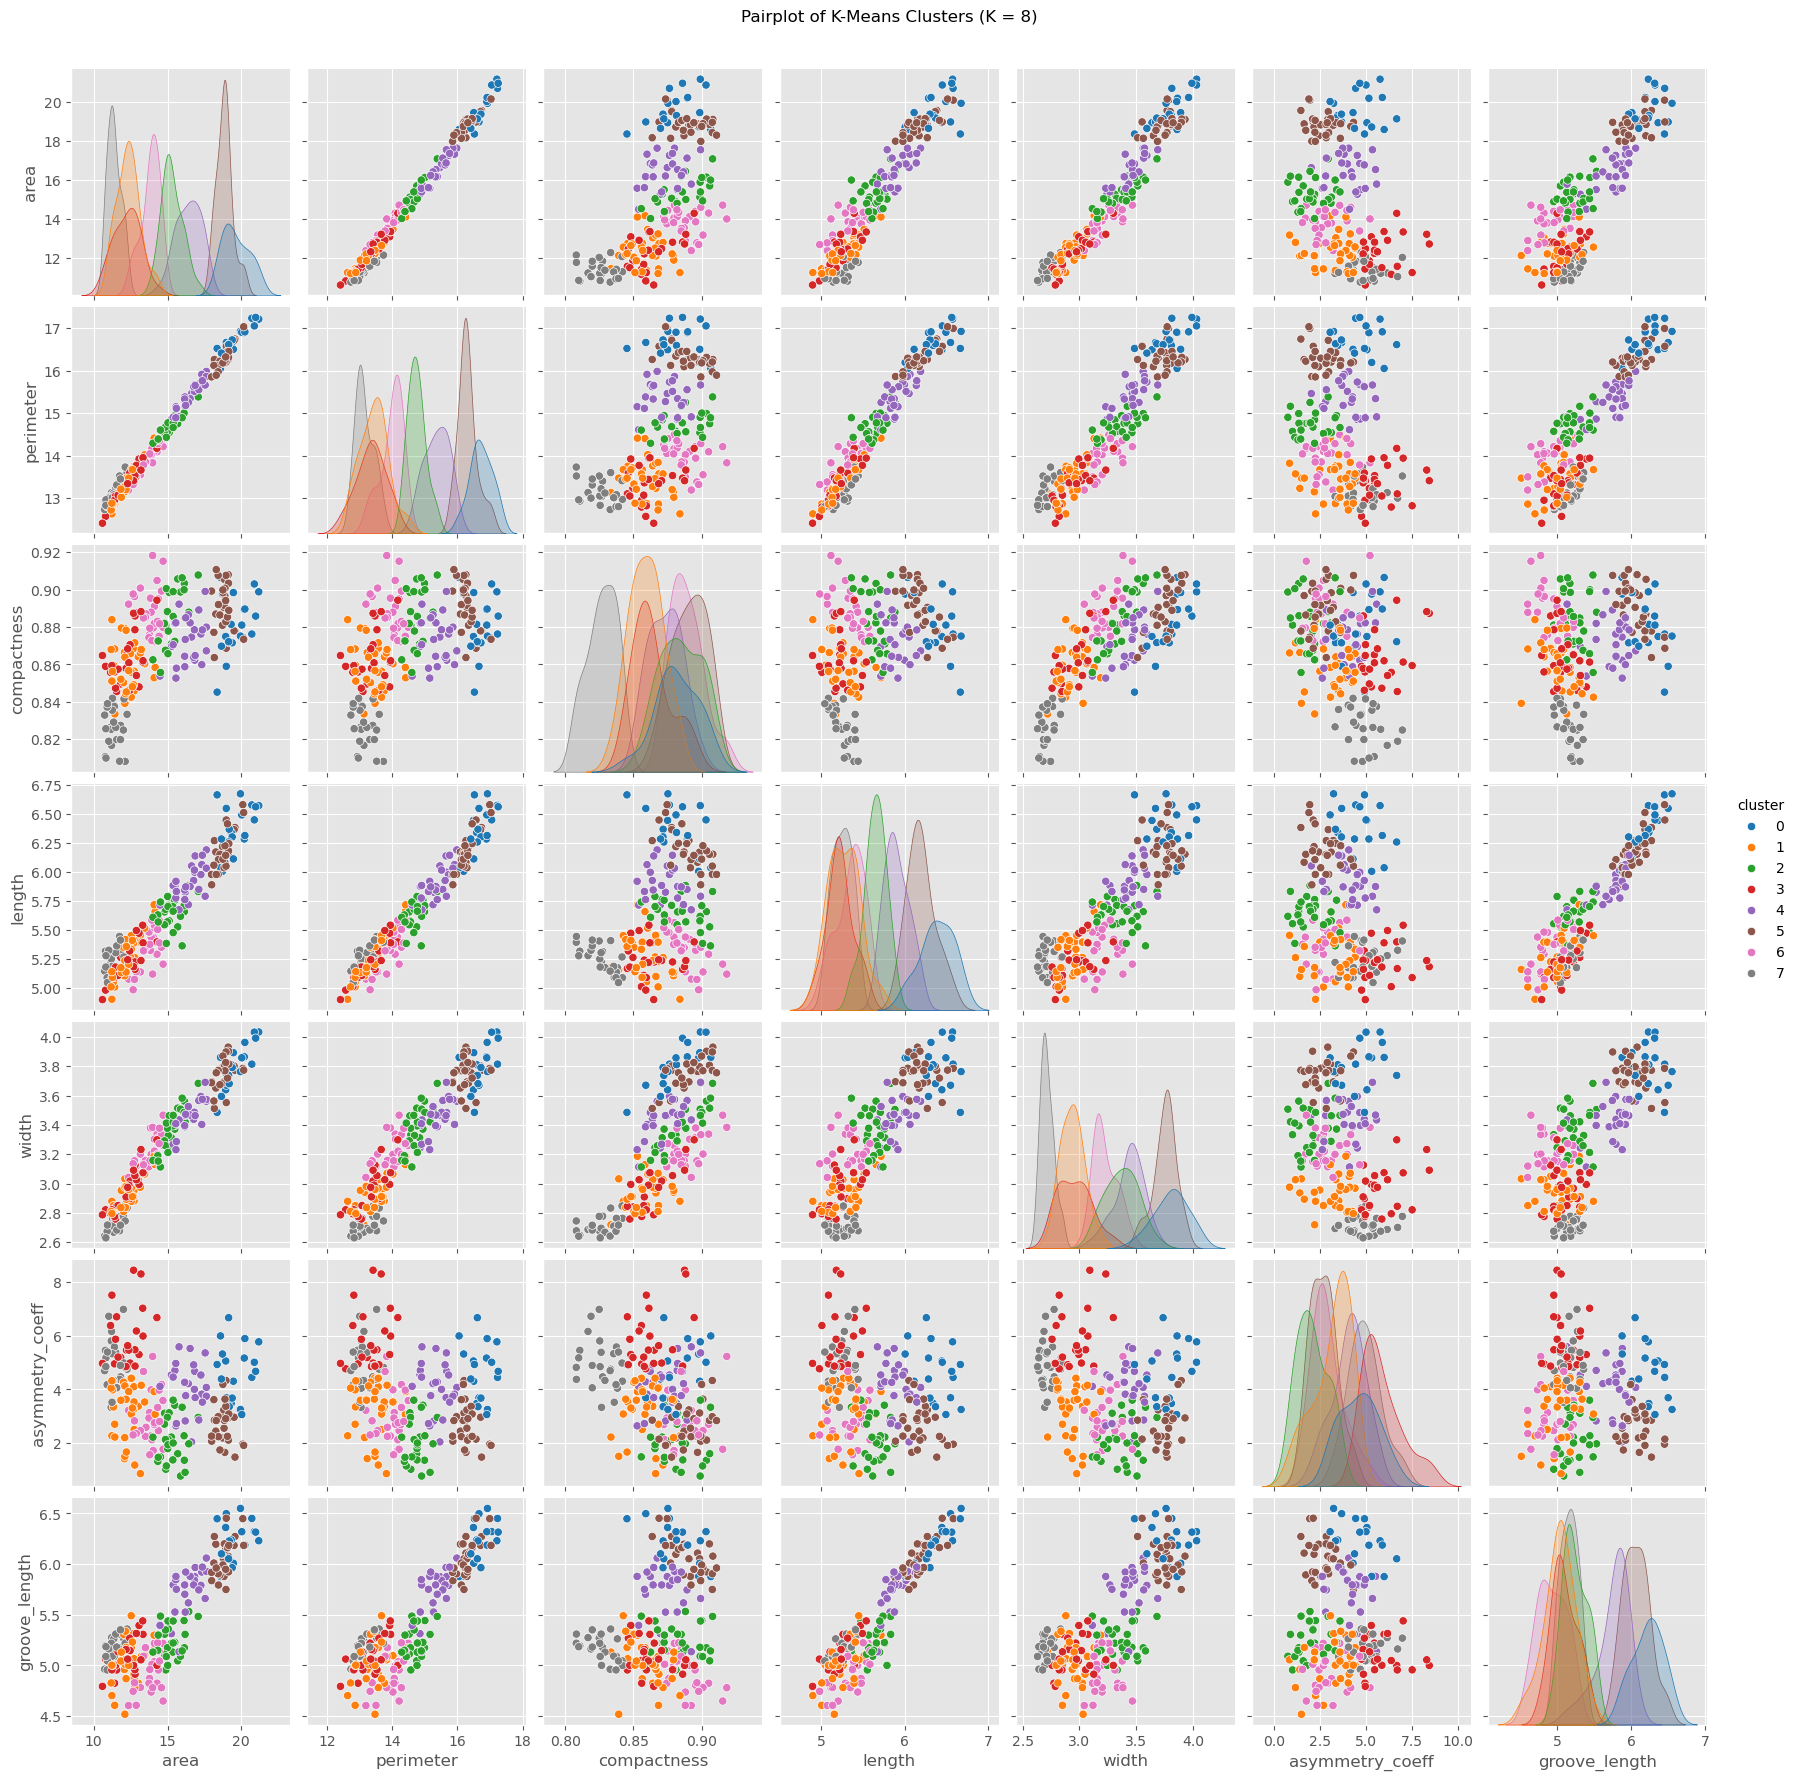

In [15]:
# A:
feature_cols = ['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry_coeff', 'groove_length']
vis_df = seeds[feature_cols].copy()
vis_df['cluster'] = km.labels_  
sns.pairplot(vis_df, vars=feature_cols, hue='cluster', diag_kind='kde', palette='tab10')
plt.suptitle("Pairplot of K-Means Clusters (K = 8)", y=1.02)
plt.show()

### 7. Repeat steps #4 and #6 with two selected or random K values and compare the results to the k=8 model.

In [16]:
# K-Means with K = 3
km2 = KMeans(n_clusters=3, random_state=42)
km2.fit(X_scaled)
labels2 = km2.labels_
score2 = silhouette_score(X_scaled, labels2)
print("Silhouette Score (K=3):", score2)

Silhouette Score (K=3): 0.4024370101867174


In [17]:
# K-Means with K = 5
km3 = KMeans(n_clusters=5, random_state=42)
km3.fit(X_scaled)
labels3 = km3.labels_
score3 = silhouette_score(X_scaled, labels3)
print("Silhouette Score (K=5):", score3)

Silhouette Score (K=5): 0.26605166264907826


In [18]:
comparison = pd.DataFrame({
    "K": [8, 3, 5],
    "Silhouette Score": [score, score2, score3]
})
comparison

,K,Silhouette Score
0,8,0.247230
1,3,0.402437
2,5,0.266052


### 8. Build a function to find the optimal number of clusters using silhouette score as the criteria.
1. Function should accept a range and a dataframe as arguments
2. Returns the optimal K value, associate silhoutte and scaling method.
3. Your function should also consider the scaled results of the data. 
    - `normalize`, `StandardScaler`, `MinMaxScaler`


Once you have found the optimal K and version of the data, visualize the clusters.





In [19]:
def best_k(data, k_values):
    results = []
    sc = StandardScaler()
    X_scaled = sc.fit_transform(data)
    for k in k_values:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X_scaled)
        labels = km.labels_
        score = silhouette_score(X_scaled, labels)
        results.append([k, "StandardScaler", score])
        
    mm = MinMaxScaler()
    X_minmax = mm.fit_transform(data)
    for k in k_values:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X_minmax)
        labels = km.labels_
        score = silhouette_score(X_minmax, labels)
        results.append([k, "MinMaxScaler", score])
        
    X_norm = normalize(data)
    for k in k_values:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X_norm)
        labels = km.labels_
        score = silhouette_score(X_norm, labels)
        results.append([k, "Normalize", score])
        
    df = pd.DataFrame(results, columns=["K", "Scaling", "Silhouette"])
    best = df.sort_values("Silhouette", ascending=False).iloc[0]
    return df, best

In [20]:
k_value = range(2, 15)
results, best = best_k(X, k_value)

print("Best K:", best["K"])
print("Best Scaler:", best["Scaling"])
print("Best Silhouette Score:", best["Silhouette"])

Best K: 2
Best Scaler: MinMaxScaler
Best Silhouette Score: 0.505113885588951


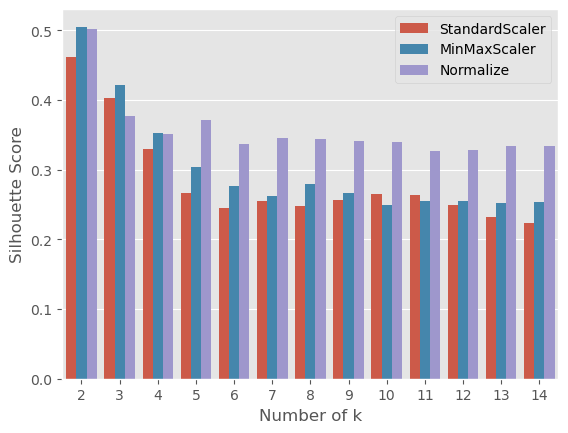

In [21]:
sns.barplot(data=results, x="K", y="Silhouette", hue="Scaling")
plt.ylabel("Silhouette Score")
plt.xlabel("Number of k")
plt.legend()
plt.show()